In [7]:
import argparse
import numpy as np
import sys
import pickle
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from gcforest.gcforest import GCForest
from gcforest.utils.config_utils import load_json

In [8]:
def get_files(dir_path):
    return [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

dataset_samples = []
dataset_labels = []

def read_dataset_dir(dir_path, label, dataset_samples, dataset_labels):
    for filename in get_files(dir_path):
        image = cv2.cvtColor(cv2.imread(os.path.join(dir_path, filename)), cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (24, 72))
        dataset_samples.append(image)
        dataset_labels.append(label)

red_samples, red_labels = [], []
read_dataset_dir('data/simulator/red', 0, red_samples, red_labels)
read_dataset_dir('data/udacity-sdc/red', 0, red_samples, red_labels)

yellow_samples, yellow_labels = [], []
read_dataset_dir('data/simulator/yellow', 1, yellow_samples, yellow_labels)
read_dataset_dir('data/udacity-sdc/yellow', 1, yellow_samples, yellow_labels)

green_samples, green_labels = [], []
read_dataset_dir('data/udacity-sdc/green', 2, green_samples, green_labels)
read_dataset_dir('data/simulator/green', 2, green_samples, green_labels)

red_samples = np.array(red_samples)
red_labels = np.array(red_labels)

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(
    red_samples,
    red_labels,
    test_size=0.05,
    random_state=42
)

X_yellow_train, X_yellow_test, y_yellow_train, y_yellow_test = train_test_split(
    yellow_samples,
    yellow_labels,
    test_size=0.05,
    random_state=42
)

X_green_train, X_green_test, y_green_train, y_green_test = train_test_split(
    green_samples,
    green_labels,
    test_size=0.05,
    random_state=42
)

X_train = np.concatenate([X_red_train, X_yellow_train, X_green_train], axis=0)
y_train = np.concatenate([y_red_train, y_yellow_train, y_green_train], axis=0)

X_test = np.concatenate([X_red_test, X_yellow_test, X_green_test], axis=0)
y_test = np.concatenate([y_red_test, y_yellow_test, y_green_test], axis=0)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(858, 72, 24, 3)
(858,)
(47, 72, 24, 3)
(47,)


In [10]:
n_train = X_train.shape [0]
n_test = X_test.shape [0]
image_shape = X_train.shape [1:3]
n_classes = 3

In [11]:
#rescaling of pixel magnitudes
X_train_preprocessed = np.divide(X_train, 255).astype (np.float32);
X_test_preprocessed = np.divide(X_test, 255).astype (np.float32);

n_train_classes = [np.count_nonzero(y_train==i) for i in range (n_classes)] 
n_test_classes = [np.count_nonzero(y_test==i) for i in range (n_classes)] 

#dividing into train and validation dataset
def shuffle_dataset (dataset_x, dataset_y):
    assert len (dataset_x) == len (dataset_y)
    p = np.random.permutation(len(dataset_x))
    return dataset_x [p], dataset_y [p]

def train_validation_split (dataset_x, dataset_y, train_proportion):
    train_samples_by_classes = []
    train_labels_by_classes = []
    X_train_samples = np.zeros ((0, image_shape[0], image_shape[1], 3))
    y_train_samples = np.zeros ((0,))
    X_validation_samples = np.zeros ((0, image_shape[0], image_shape[1], 3))
    y_validation_samples = np.zeros ((0,))
    sample_index = 0
    for class_size in n_train_classes:
        train_samples_count = int(train_proportion * class_size)

        #getting and shuffle one class samples
        dataset_x_for_class = dataset_x[sample_index:sample_index + class_size]
        dataset_y_for_class = dataset_y[sample_index:sample_index + class_size]
        dataset_x_for_class, dataset_y_for_class = shuffle_dataset (dataset_x_for_class, dataset_y_for_class)
        
        #splitting to train and validation dataset
        X_train_for_class = dataset_x_for_class[0:train_samples_count]
        y_train_for_class = dataset_y_for_class[0:train_samples_count]
        X_valid_for_class = dataset_x_for_class[train_samples_count:class_size]
        y_valid_for_class = dataset_y_for_class[train_samples_count:class_size]
        
        #storing train samples by classes
        #this will be used later to generate augmented dataset
        train_samples_by_classes.append (X_train_for_class)
        train_labels_by_classes.append (y_train_for_class)
        
        #storing samples in corresponding datasets
        X_train_samples = np.concatenate((X_train_samples, X_train_for_class), axis=0)
        y_train_samples = np.concatenate((y_train_samples, y_train_for_class), axis=0)
        X_validation_samples = np.concatenate((X_validation_samples, X_valid_for_class), axis=0)
        y_validation_samples = np.concatenate((y_validation_samples, y_valid_for_class), axis=0)
        
        sample_index += class_size
        
    return X_train_samples, y_train_samples, X_validation_samples, y_validation_samples, train_samples_by_classes, train_labels_by_classes

X_train_s, y_train_s, X_valid_s, y_valid_s, train_samples, labels_by_classes = train_validation_split (
    X_train_preprocessed, y_train, 0.8)

In [12]:
print(X_train_s.shape)
print(y_train_s.shape)
print(X_valid_s.shape)
print(y_valid_s.shape)
print(len(train_samples[0]))
print(len(labels_by_classes[0]))

(685, 72, 24, 3)
(685,)
(173, 72, 24, 3)
(173,)
464
464


In [13]:
import random as rand

# generate @generate_count images from given @images
def augment_images (images, generate_count):
    images_last_index = len (images) - 1
    augmented = []
    for i in range (generate_count):
        im1 = images [rand.randint (0, images_last_index)]
        
        #rotation and scaling
        Mrot = cv2.getRotationMatrix2D((16,16),rand.uniform(-5.0, 5.0), rand.uniform(0.95, 1.05))

        #affine transform and shifts
        pts1 = np.float32([[0,0],[image_shape[1],0],[image_shape[1], image_shape[0]]])
        a = 5;
        shift = 8
        shiftx = rand.randint (-shift, shift);
        shifty = rand.randint (-shift, shift);
        pts2 = np.float32([[
                    0 + rand.randint (-a, a) + shiftx,
                    0 + rand.randint (-a, a) + shifty
                ],[
                    image_shape[1] + rand.randint (-a, a) + shiftx,
                    0 + rand.randint (-a, a) + shifty
                ],[
                    image_shape[1] + rand.randint (-a, a) + shiftx,
                    image_shape[0] + rand.randint (-a, a) + shifty
                ]])
        M = cv2.getAffineTransform(pts1,pts2)
        (h, w) = im1.shape[:2]

        augmented_image = cv2.warpAffine(
            cv2.warpAffine (
                im1
                , Mrot, (w, h)
            )
            , M, (w,h)
        )
        
        augmented_image += rand.uniform(-0.2, 0.2)
        np.clip(augmented_image, 0.0, 1.0, out=augmented_image)
        
        augmented.append (augmented_image)
        
    return augmented

In [14]:
#augmented dataset will be stored in this global variables
X_train_augmented = np.zeros ((0, image_shape[0], image_shape[1], 3))
y_train_augmented = np.zeros ((0,))

#generate images up to 3000 images for each class
#augmented dataset will contain only generated images
augment_limit = 3000
def augment_dataset ():
    global X_train_augmented
    global y_train_augmented
    X_train_augmented = np.zeros ((0, image_shape[0], image_shape[1], 3))
    y_train_augmented = np.zeros ((0,))
    
    for augmenting_index in range(n_classes):
        samples = train_samples[augmenting_index]
        labels = labels_by_classes [augmenting_index]

        augment_count = augment_limit
        new_samples = augment_images (samples, augment_count)
        y_train_augmented = np.concatenate((y_train_augmented, [augmenting_index for i in range (augment_count)]), axis=0)

        X_train_augmented = np.concatenate((X_train_augmented, new_samples), axis=0)

In [15]:
augment_dataset ()
print(X_train_augmented.shape)
print(y_train_augmented.shape)

(9000, 72, 24, 3)
(9000,)


In [16]:
train_dataset_x, train_dataset_y = shuffle_dataset (X_train_augmented, y_train_augmented)

In [17]:
#GC Model

In [18]:
def get_toy_config():
    config = {}
    ca_config = {}
    ca_config["random_state"] = 0
    ca_config["max_layers"] = 100
    ca_config["early_stopping_rounds"] = 3
    ca_config["n_classes"] = n_classes
    ca_config["estimators"] = []
#     ca_config["estimators"].append(
#              {"n_folds": 5, "type": "XGBClassifier", "n_estimators": 10, "max_depth": 5,
#               "objective": "multi:softprob", "silent": True, "nthread": -1, "learning_rate": 0.1} )
#     ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "n_estimators": 10, "max_depth": None, "n_jobs": -1})
    ca_config["estimators"].append({"n_folds": 1, "type": "ExtraTreesClassifier", "n_estimators": 10, "max_depth": None, "n_jobs": -1})
#     ca_config["estimators"].append({"n_folds": 5, "type": "LogisticRegression"})
    config["cascade"] = ca_config
    return config

In [19]:
config = get_toy_config()
gc = GCForest(config)
# If the model you use cost too much memory for you.
# You can use these methods to force gcforest not keeping model in memory
# gc.set_keep_model_in_mem(False), default is TRUE.
n_test = 500
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, y_train = train_dataset_x[:-n_test], train_dataset_y[:-n_test]
X_test, y_test = train_dataset_x[-n_test:], train_dataset_y[-n_test:]

X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8500, 1, 72, 24, 3)
(8500,)
(500, 1, 72, 24, 3)
(500,)


In [20]:
#Fit
X_train_enc = gc.fit_transform(X_train, y_train)
# X_enc is the concatenated predict_proba result of each estimators of the last layer of the GCForest model
# X_enc.shape =
#   (n_datas, n_estimators * n_classes): If cascade is provided
#   (n_datas, n_estimators * n_classes, dimX, dimY): If only finegrained part is provided
# You can also pass X_test, y_test to fit_transform method, then the accracy on test data will be logged when training.
# X_train_enc, X_test_enc = gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test)
# WARNING: if you set gc.set_keep_model_in_mem(True), you would have to use
# gc.fit_transform(X_train, y_train, X_test=X_test, y_test=y_test) to evaluate your model.

[ 2018-02-20 16:18:23,128][cascade_classifier.fit_transform] X_groups_train.shape=[(8500, 1, 72, 24, 3)],y_train.shape=(8500,),X_groups_test.shape=no_test,y_test.shape=no_test
[ 2018-02-20 16:18:23,240][cascade_classifier.fit_transform] group_dims=[5184]
[ 2018-02-20 16:18:23,241][cascade_classifier.fit_transform] group_starts=[0]
[ 2018-02-20 16:18:23,241][cascade_classifier.fit_transform] group_ends=[5184]
[ 2018-02-20 16:18:23,242][cascade_classifier.fit_transform] X_train.shape=(8500, 5184),X_test.shape=(0, 5184)
[ 2018-02-20 16:18:23,351][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(8500, 5184), X_cur_test.shape=(0, 5184)
[ 2018-02-20 16:19:50,609][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 5_folds.train_0.predict)=95.77%
[ 2018-02-20 16:21:17,839][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 5_folds.train_1.predict)=95.77%
[ 2018-02-20 16:22:44,825][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - esti

In [21]:
y_pred = gc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of GcForest = {:.2f} %".format(acc * 100))

[ 2018-02-20 16:35:42,410][cascade_classifier.transform] X_groups_test.shape=[(500, 1, 72, 24, 3)]
[ 2018-02-20 16:35:42,421][cascade_classifier.transform] group_dims=[5184]
[ 2018-02-20 16:35:42,422][cascade_classifier.transform] X_test.shape=(500, 5184)
[ 2018-02-20 16:35:42,431][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(500, 5184)


Test Accuracy of GcForest = 99.20 %


Test Accuracy of GcForest = 100.00 %
RED


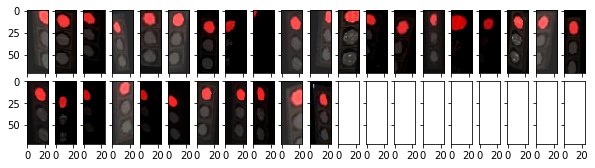

YELLOW


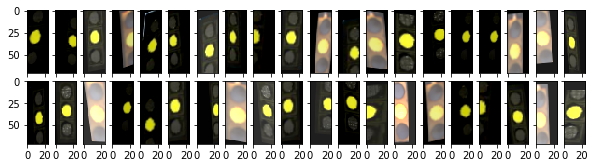

GREEN


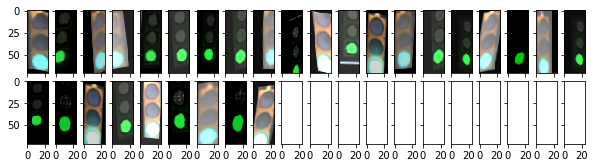

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


def show_images_in_grid (images, rows, cols):
    fig = plt.figure (figsize=(10., 15.))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(rows, cols),
                     axes_pad=0.1
                     )
    for i in range(len (images)):
        grid[i].imshow(images [i])

    plt.show()
    
#table of traffic sign examples for diffetent classes
# im_pos = 0
X_test_examples_red = []
X_test_examples_yellow = []
X_test_examples_green = []

import random
n_prints = 100
for i in range(n_prints):
    ix = random.randint(1, y_test.shape[0])
    if(y_test[ix] == 0):
        #print('RED')
        X_test_examples_red.append(X_test[ix][0])
        
    elif(y_test[ix] == 1):
        #print('YELLOW')
        X_test_examples_yellow.append(X_test[ix][0])
    else:
        #print('GREEN')
        X_test_examples_green.append(X_test[ix][0])

print("Test Accuracy of GcForest = {:.2f} %".format(acc * 100))        
print('RED')
show_images_in_grid(X_test_examples_red, 2, 20)
print('YELLOW')
show_images_in_grid(X_test_examples_yellow, 2, 20)
print('GREEN')
show_images_in_grid(X_test_examples_green, 2, 20)

In [41]:
y_pred = gc.predict(X_valid_s)
acc = accuracy_score(y_valid_s, y_pred)
print(acc)

[ 2018-02-20 18:53:08,543][cascade_classifier.transform] X_groups_test.shape=[(173, 72, 24, 3)]
[ 2018-02-20 18:53:08,547][cascade_classifier.transform] group_dims=[5184]
[ 2018-02-20 18:53:08,547][cascade_classifier.transform] X_test.shape=(173, 5184)
[ 2018-02-20 18:53:08,551][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(173, 5184)


1.0


In [43]:
X_valid_s.shape

(173, 72, 24, 3)

RED


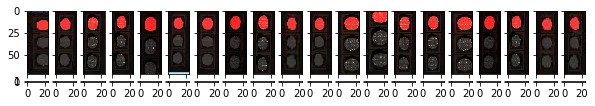

YELLOW


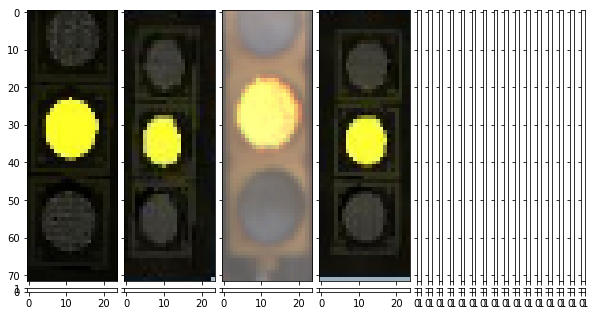

GREEN


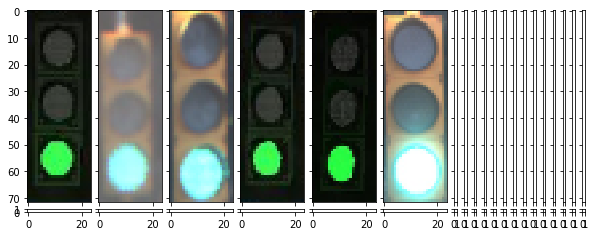

In [42]:
#table of traffic sign examples for diffetent classes
# im_pos = 0
X_val_examples_red = []
X_val_examples_yellow = []
X_val_examples_green = []

import random
n_prints = 30
for i in range(n_prints):
    ix = random.randint(1, y_valid_s.shape[0])
    if(y_valid_s[ix] == 0):
        #print('RED')
        X_val_examples_red.append(X_valid_s[ix])
        
    elif(y_valid_s[ix] == 1):
        #print('YELLOW')
        X_val_examples_yellow.append(X_valid_s[ix])
    else:
        #print('GREEN')
        X_val_examples_green.append(X_valid_s[ix])

        
print('RED')
show_images_in_grid(X_val_examples_red, 2, 20)
print('YELLOW')
show_images_in_grid(X_val_examples_yellow, 2, 20)
print('GREEN')
show_images_in_grid(X_val_examples_green, 2, 20)

In [33]:
# save the model to disk
with open("test.pkl", "wb") as f:
    pickle.dump(gc, f, pickle.HIGHEST_PROTOCOL)
# load
with open("test.pkl", "rb") as f:
    gc = pickle.load(f)
y_pred = gc.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy of GcForest (save and load) = {:.2f} %".format(acc * 100))

[ 2018-02-20 17:29:25,315][cascade_classifier.transform] X_groups_test.shape=[(500, 1, 72, 24, 3)]
[ 2018-02-20 17:29:25,324][cascade_classifier.transform] group_dims=[5184]
[ 2018-02-20 17:29:25,325][cascade_classifier.transform] X_test.shape=(500, 5184)
[ 2018-02-20 17:29:25,334][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(500, 5184)


Test Accuracy of GcForest (save and load) = 99.20 %


In [36]:
X_valid_s

array([[[[0.41176471, 0.38431373, 0.39215687],
         [0.51372552, 0.44705883, 0.47843137],
         [0.47450981, 0.42745098, 0.43529412],
         ...,
         [0.36862746, 0.33333334, 0.35294119],
         [0.35294119, 0.32941177, 0.32941177],
         [0.34117648, 0.32156864, 0.34901962]],

        [[0.36470589, 0.32941177, 0.36078432],
         [0.42352942, 0.36470589, 0.41568628],
         [0.40000001, 0.36470589, 0.3882353 ],
         ...,
         [0.36078432, 0.33333334, 0.34901962],
         [0.36470589, 0.32941177, 0.35686275],
         [0.34901962, 0.32156864, 0.34901962]],

        [[0.47058824, 0.33725491, 0.32941177],
         [0.49411765, 0.34509805, 0.32549021],
         [0.50196081, 0.35686275, 0.32941177],
         ...,
         [0.38431373, 0.32156864, 0.34117648],
         [0.38039216, 0.32549021, 0.38431373],
         [0.36078432, 0.32941177, 0.35686275]],

        ...,

        [[0.36862746, 0.32941177, 0.34509805],
         [0.4627451 , 0.37254903, 0.34509805]